#1. Loading Necessary Libraries

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/Shareddrives/ISEN 613 Final Project/ISEN613-Engineering-Data-Analysis-CourseProject-main"


Mounted at /content/drive
'CNN code and input'
 CNN_Implementation_Code.ipynb
 Ground_Truth_Sample1
 Ground_Truth_Sample4
'~$Ground Truth - Voxel Tensor Index_ Sample1.xlsx'
'Ground Truth - Voxel Tensor Index_ Sample1.xlsx'
'*.mat'
 README.md
 Spectrogram_Tensors_Sample1.mat
 Spectrogram_Tensors_Sample4.mat
 test.ipynb


In [2]:
# cnn model and accuracy - porosity tensor dataset
# Import packages / libraries

import os
from os.path import dirname, join as pjoin
import scipy.io
import tensorflow as tf
import torch

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random

# baseline model for the classification dataset
import sys
from matplotlib import pyplot
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

!pip install opencv-python
!pip install lime 
!pip install lazypredict

import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from skimage.color import gray2rgb
from skimage.color import rgb2gray
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import inception_v3 as inc_net
from lime import lime_image
import pandas as pd
import glob
from tensorflow.keras.models import load_model
from sklearn.metrics import r2_score
import cv2
from keras.preprocessing.image import ImageDataGenerator
from skimage.segmentation import mark_boundaries

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 5.6 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=2b553737f36af1fb869b644fb25d6d9d7e05a56d2375011c87491dbd1df1f884
  Stored in directory: /root/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
## LIME ANALYSIS
## Import required libraries / packages

import numpy as np
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import math
import scipy
import scipy.io
from PIL import Image
from scipy import ndimage
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
# import tensorflow_addons as tfa
import pydot
import pydotplus
import graphviz
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
import random
from keras.models import load_model
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import glob
import os
import pandas as pd

import types
from lime.utils.generic_utils import has_arg
from skimage.segmentation import felzenszwalb, slic, quickshift
import copy
from functools import partial

import sklearn
import sklearn.preprocessing
from sklearn.utils import check_random_state
from skimage.color import gray2rgb
from tqdm.auto import tqdm

import scipy.ndimage as ndi
from skimage.segmentation._quickshift_cy import _quickshift_cython

from lime import lime_base
from lime.wrappers.scikit_image import SegmentationAlgorithm

import skimage
from matplotlib import colors
from skimage.segmentation import mark_boundaries, find_boundaries
from skimage.morphology import dilation,square
from collections import Counter
import re
from sklearn.ensemble import RandomForestRegressor



#2. Input Processing
In this section, inputs are loaded into tensor-type variables and converted to numpy-type.

In [4]:
from numpy.core.fromnumeric import shape
# organize dataset into a numpy structure
# Extract input spectrogram data from .mat files 
# Loading the ground truth xlsx file
gt = pd.read_excel(r"/content/drive/Shareddrives/ISEN 613 Final Project/ISEN613-Engineering-Data-Analysis-CourseProject-main/CNN code and input/Ground Truth - Voxel Tensor Index_ Sample1.xlsx")
perc_area = gt.iloc[0:90, [1,5]]
pore_count = gt.iloc[0:90,[1,2]]

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
# sets print options to 5 decimal places

TENSOR_INPUT_DATA_COMBINED = torch.ones((72,6,129,15))
TENSOR_INPUT_DATA_PRINTING = torch.ones((72,4,129,15))
TENSOR_INPUT_DATA_MILLING = torch.ones((72,2,129,15))
    
    # 72 - Total number of data points for binary classification
    # 6 - Channels (pertaining to each spectrogram)
    # 129  - Freuqency bands for each spectrogram
    # 15 - Time steps

voxel_number = 0

# assign directory
# directory = 'files'
# iterate over files in that directory
# for filename in os.listdir(directory):


directory = (r"/content/drive/Shareddrives/ISEN 613 Final Project/ISEN613-Engineering-Data-Analysis-CourseProject-main/CNN code and input/Tensor_data_72_voxels_sample1")
# Change this directory location to your folder that contains the 72 .mat files from Tensor_data_72_voxels.zip corresponding to Sample 1.
# When working with Sample 4 (Tensor_data_90_voxels_sample4.zip), extract the 90 files in a folder, and update the directory. In addition, 
# update the dimensions in the below for loop (and in other places as required) as each tensor in Sample 4 is of dimension 129x6x4, 
# ie, 129 frequency bands, 6 time steps, 4 spectrograms pertaining to only printing cycle. 

voxel_perc_area = []
voxel_pore_count = []
class_comb_area = np.zeros((72,2))
class_comb_count = np.zeros((72,2))
reg_comb = np.zeros((72,2))

for filename in os.listdir(directory):
    # print(filename)
    mat_fname = pjoin(directory, filename)
    Tensor_data_voxel = scipy.io.loadmat(mat_fname)

    data = list(Tensor_data_voxel. items())
    tensor_array = np.array(data, dtype=object)

    # The spectrogram data is captured in a list from one of the elements of tensor_array
    # Shape of tensor_array is (4,2) and all spectrogram data (129x15x6) is stored in tensor_array[3][1]

    spec_list = list(tensor_array[3][1])
    
    # Extracting the desired output to build the different datasets
    voxel_name = tensor_array[3][0]
    voxel_ind = [int(s) for s in re.findall(r'\d+', voxel_name)][0]
    voxel_perc_area.append(np.array(perc_area.loc[perc_area['Tensor_voxel _index'] == voxel_ind, '%Area Porosity'])[0])
    voxel_pore_count.append(np.array(pore_count.loc[perc_area['Tensor_voxel _index'] == voxel_ind, 'Pore Count'])[0])

    for i in range(len(spec_list)):
        for j in range(15):
            for k in range(6):
                TENSOR_INPUT_DATA_COMBINED[voxel_number,k,i,j] = spec_list[i][j][k]
                    
    TENSOR_INPUT_DATA_PRINTING = TENSOR_INPUT_DATA_COMBINED[:,(1,2,4,5),:,:]
    TENSOR_INPUT_DATA_MILLING = TENSOR_INPUT_DATA_COMBINED[:,(0,3),:,:]                

    voxel_number = voxel_number + 1

# for i in range(72):
#   class_comb_area[i][0] = tensor_np[i]
#   class_comb_count[i][0] = tensor_np[i]
#   reg_comb[i][0] = tensor_np[i]

#   class_comb_area[i][1] = voxel_perc_area[i]
#   class_comb_count[i][1] = voxel_pore_count[i]
#   reg_comb[i][1] = voxel_perc_area[i]


y_target_area = np.array([voxel_perc_area[i] for i in range(72)])
y_target_count = np.array([voxel_pore_count[i] for i in range(72)])

# y_target[4:10] = 1
# y_target[13:18] = 1
# y_target[22:34] = 1
# y_target[37:41] = 1
# y_target[43:46] = 1
# y_target[47] = 1
# y_target[57] = 1
# y_target[59] = 1
# y_target[70] = 1

data_order = np.arange(72)
np.random.shuffle(data_order)

'''
print("---------------------")
print(TENSOR_INPUT_DATA_COMBINED.shape)
print(TENSOR_INPUT_DATA_COMBINED)
print(TENSOR_INPUT_DATA_PRINTING.shape)
print(TENSOR_INPUT_DATA_PRINTING)
print(TENSOR_INPUT_DATA_MILLING.shape)
print(TENSOR_INPUT_DATA_MILLING)
print("---------------------")
print(y_target)
print("---------------------")
data_order = np.arange(72)
np.random.shuffle(data_order)
print(data_order)
'''


'\nprint("---------------------")\nprint(TENSOR_INPUT_DATA_COMBINED.shape)\nprint(TENSOR_INPUT_DATA_COMBINED)\nprint(TENSOR_INPUT_DATA_PRINTING.shape)\nprint(TENSOR_INPUT_DATA_PRINTING)\nprint(TENSOR_INPUT_DATA_MILLING.shape)\nprint(TENSOR_INPUT_DATA_MILLING)\nprint("---------------------")\nprint(y_target)\nprint("---------------------")\ndata_order = np.arange(72)\nnp.random.shuffle(data_order)\nprint(data_order)\n'

In [5]:
# Saving data as .npy files
NUMPY_INPUT_DATA = TENSOR_INPUT_DATA_COMBINED.numpy()
NUMPY_INPUT_DATA_printing = TENSOR_INPUT_DATA_PRINTING.numpy()
NUMPY_INPUT_DATA_milling = TENSOR_INPUT_DATA_MILLING.numpy()

np.save(r"/content/drive/Shareddrives/ISEN 613 Final Project/ISEN613-Engineering-Data-Analysis-CourseProject-main/CNN code and input/Saved Inputs_Outputs/Comb_Inputs", NUMPY_INPUT_DATA)
np.save(r"/content/drive/Shareddrives/ISEN 613 Final Project/ISEN613-Engineering-Data-Analysis-CourseProject-main/CNN code and input/Saved Inputs_Outputs/Print_Inputs", NUMPY_INPUT_DATA_printing)
np.save(r"/content/drive/Shareddrives/ISEN 613 Final Project/ISEN613-Engineering-Data-Analysis-CourseProject-main/CNN code and input/Saved Inputs_Outputs/Mill_Inputs", NUMPY_INPUT_DATA_milling)
np.save(r"/content/drive/Shareddrives/ISEN 613 Final Project/ISEN613-Engineering-Data-Analysis-CourseProject-main/CNN code and input/Saved Inputs_Outputs/Target_Area", y_target_area)
np.save(r"/content/drive/Shareddrives/ISEN 613 Final Project/ISEN613-Engineering-Data-Analysis-CourseProject-main/CNN code and input/Saved Inputs_Outputs/Target_Count", y_target_count)

# 3. Regression


###3.1. Combined Data

In [7]:
NUMPY_INPUT_DATA = TENSOR_INPUT_DATA_COMBINED.numpy()

X_train_reg = NUMPY_INPUT_DATA[data_order[0:64],:,:,:]
y_train_reg = y_target_area[data_order[0:64]]
X_test_reg = NUMPY_INPUT_DATA[data_order[64:72],:,:,:]
y_test_reg = y_target_area[data_order[64:72]]
    
# Define the model architecture
model = Sequential()
model.add(Conv2D(6, (7, 7), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(6, 129, 15)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(1, (7, 7), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(6, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
#opt = SGD(lr=0.001, momentum=0.9)

model.compile(loss='mean_squared_error', optimizer='adam', metrics='mse')

model.fit(X_train_reg, y_train_reg,
          epochs=200,
          verbose=1,
          validation_data=(X_test_reg, y_test_reg))
score = model.evaluate(X_test_reg, y_test_reg, verbose=0)
print('Model MSE:', score[0])

Epoch 1/200
2/2 [==============================] - 3s 2s/step - loss: 3.0709 - mse: 3.0709 - val_loss: 1.7817 - val_mse: 1.7817
Epoch 2/200
2/2 [==============================] - 0s 146ms/step - loss: 2.9411 - mse: 2.9411 - val_loss: 1.7695 - val_mse: 1.7695
Epoch 3/200
2/2 [==============================] - 0s 151ms/step - loss: 2.9277 - mse: 2.9277 - val_loss: 1.7669 - val_mse: 1.7669
Epoch 4/200
2/2 [==============================] - 0s 168ms/step - loss: 2.9252 - mse: 2.9252 - val_loss: 1.7661 - val_mse: 1.7661
Epoch 5/200
2/2 [==============================] - 1s 962ms/step - loss: 2.9241 - mse: 2.9241 - val_loss: 1.7658 - val_mse: 1.7658
Epoch 6/200
2/2 [==============================] - 1s 859ms/step - loss: 2.9237 - mse: 2.9237 - val_loss: 1.7657 - val_mse: 1.7657
Epoch 7/200
2/2 [==============================] - 0s 151ms/step - loss: 2.9236 - mse: 2.9236 - val_loss: 1.7657 - val_mse: 1.7657
Epoch 8/200
2/2 [==============================] - 1s 708ms/step - loss: 2.9235 - mse:

## 3.2. Printing

In [9]:
NUMPY_INPUT_DATA_printing = TENSOR_INPUT_DATA_PRINTING.numpy()

X_train_reg_printing = NUMPY_INPUT_DATA_printing[data_order[0:64],:,:,:]
y_train_reg = y_target_area[data_order[0:64]]
X_test_reg_printing = NUMPY_INPUT_DATA_printing[data_order[64:72],:,:,:]
y_test_reg = y_target_area[data_order[64:72]]
    
# Define the model architecture
model = Sequential()
model.add(Conv2D(6, (7, 7), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(4, 129, 15)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(1, (7, 7), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(6, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
#opt = SGD(lr=0.001, momentum=0.9)

model.compile(loss='mean_squared_error', optimizer='adam', metrics='mse')

model.fit(X_train_reg_printing, y_train_reg,
          epochs=500,
          verbose=1,
          validation_data=(X_test_reg_printing, y_test_reg))
score = model.evaluate(X_test_reg_printing, y_test_reg, verbose=0)
print('Model MSE:', score[0])


Epoch 1/500
2/2 [==============================] - 3s 1s/step - loss: 4.1393 - mse: 4.1393 - val_loss: 2.3610 - val_mse: 2.3610
Epoch 2/500
2/2 [==============================] - 0s 192ms/step - loss: 3.7438 - mse: 3.7438 - val_loss: 2.1643 - val_mse: 2.1643
Epoch 3/500
2/2 [==============================] - 1s 1s/step - loss: 3.4323 - mse: 3.4323 - val_loss: 2.0515 - val_mse: 2.0515
Epoch 4/500
2/2 [==============================] - 2s 2s/step - loss: 3.2496 - mse: 3.2496 - val_loss: 1.9399 - val_mse: 1.9399
Epoch 5/500
2/2 [==============================] - 1s 910ms/step - loss: 3.1326 - mse: 3.1326 - val_loss: 1.8664 - val_mse: 1.8664
Epoch 6/500
2/2 [==============================] - 0s 110ms/step - loss: 3.0513 - mse: 3.0513 - val_loss: 1.8215 - val_mse: 1.8215
Epoch 7/500
2/2 [==============================] - 0s 122ms/step - loss: 2.9969 - mse: 2.9969 - val_loss: 1.7973 - val_mse: 1.7973
Epoch 8/500
2/2 [==============================] - 0s 116ms/step - loss: 2.9657 - mse: 2.965

## 3.3. Milling

In [10]:
NUMPY_INPUT_DATA_milling = TENSOR_INPUT_DATA_MILLING.numpy()

X_train_reg_milling = NUMPY_INPUT_DATA_milling[data_order[0:64],:,:,:]
y_train_reg = y_target_area[data_order[0:64]]
X_test_reg_milling = NUMPY_INPUT_DATA_milling[data_order[64:72],:,:,:]
y_test_reg = y_target_area[data_order[64:72]]
    
# Define the model architecture
model = Sequential()
model.add(Conv2D(6, (7, 7), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(2, 129, 15)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(1, (7, 7), activation='relu', kernel_initializer='he_uniform', padding='same'))
#model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(6, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
#opt = SGD(lr=0.001, momentum=0.9)

model.compile(loss='mean_squared_error', optimizer='adam', metrics='mse')

model.fit(X_train_reg_milling, y_train_reg,
          epochs=500,
          verbose=1,
          validation_data=(X_test_reg_milling, y_test_reg))
score = model.evaluate(X_test_reg_milling, y_test_reg, verbose=0)
print('Model MSE:', score[0])


Epoch 1/500
2/2 [==============================] - 2s 1s/step - loss: 3.9580 - mse: 3.9580 - val_loss: 2.3737 - val_mse: 2.3737
Epoch 2/500
2/2 [==============================] - 1s 1s/step - loss: 3.9008 - mse: 3.9008 - val_loss: 2.3712 - val_mse: 2.3712
Epoch 3/500
2/2 [==============================] - 3s 2s/step - loss: 3.8989 - mse: 3.8989 - val_loss: 2.3702 - val_mse: 2.3702
Epoch 4/500
2/2 [==============================] - 0s 367ms/step - loss: 3.8965 - mse: 3.8965 - val_loss: 2.3686 - val_mse: 2.3686
Epoch 5/500
2/2 [==============================] - 1s 699ms/step - loss: 3.8941 - mse: 3.8941 - val_loss: 2.3670 - val_mse: 2.3670
Epoch 6/500
2/2 [==============================] - 0s 72ms/step - loss: 3.8919 - mse: 3.8919 - val_loss: 2.3653 - val_mse: 2.3653
Epoch 7/500
2/2 [==============================] - 0s 75ms/step - loss: 3.8896 - mse: 3.8896 - val_loss: 2.3637 - val_mse: 2.3637
Epoch 8/500
2/2 [==============================] - 1s 734ms/step - loss: 3.8873 - mse: 3.8873 

# 4. Classification

## 4.1. Pore Count

In [11]:
# Specifying the response and converting it to 0,1 type
y_class_count = np.zeros(72)
for i in range(72):
  if y_target_count[i]<=np.median(y_target_count):
    y_class_count[i] = 0
  else: 
    y_class_count[i] = 1

### 4.1.1. Combined

In [12]:
# CNN Model Architecture - Printing and Milling combined cycles

NUMPY_INPUT_DATA = TENSOR_INPUT_DATA_COMBINED.numpy()


X_train_class = NUMPY_INPUT_DATA[data_order[0:64],:,:,:]
y_train_class_count = y_class_count[data_order[0:64]]
X_test_class = NUMPY_INPUT_DATA[data_order[64:72],:,:,:]
y_test_class_count = y_class_count[data_order[64:72]]


# Define the K-fold Cross Validator
kfold = KFold(n_splits=8, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
train_acc_per_fold = []
train_loss_per_fold = []
val_acc_per_fold = []
val_loss_per_fold = []
test_acc_per_fold = []
test_loss_per_fold = []

for train, val in kfold.split(X_train_class, y_train_class_count):
    
    train_acc = 0
    val_acc = 0
    test_acc = 0
    # Define the model architecture
    while(train_acc < 0.5 or val_acc < 0.5 or test_acc < 0.5):
        model = Sequential()
        model.add(Conv2D(6, (7, 7), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(6, 129, 15)))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(1, (7, 7), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
        # model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        # model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(6, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(1, activation='sigmoid'))
    
        # Compile the model
        opt = SGD(lr=0.001, momentum=0.9)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        # Fit data to model
        history = model.fit(X_train_class[train], y_train_class_count[train], epochs=100, verbose=0)
        #train_acc_per_fold.append(history.history['accuracy'])
        #train_loss_per_fold.append(history.history['loss'])
        #summarize_diagnostics(fold_no, history)
        model.save('porosity_bin_model_fold_no_'+ str(fold_no) +'.h5')
    
        # Generate generalization metrics
        train_scores = model.evaluate(X_train_class[train], y_train_class_count[train], verbose=0)
        print(f'Train Score for fold {fold_no}: {model.metrics_names[0]} of {train_scores[0]}; {model.metrics_names[1]} of {train_scores[1]*100}%')
        train_acc = train_scores[1]
        
        val_scores = model.evaluate(X_train_class[val], y_train_class_count[val], verbose=0)
        print(f'Val Score for fold {fold_no}: {model.metrics_names[0]} of {val_scores[0]}; {model.metrics_names[1]} of {val_scores[1]*100}%')
        val_acc = val_scores[1]
        
        test_scores = model.evaluate(X_test_class, y_test_class_count, steps=len(X_test_class), verbose = 0)
        print(f'Test data Score for fold {fold_no}: {model.metrics_names[0]} of {test_scores[0]}; {model.metrics_names[1]} of {test_scores[1]*100}%')
        test_acc = test_scores[1]
    
    # Increase fold number
    fold_no = fold_no + 1
    train_acc_per_fold.append(train_scores[1] * 100)
    train_loss_per_fold.append(train_scores[0])
    val_acc_per_fold.append(val_scores[1] * 100)
    val_loss_per_fold.append(val_scores[0])
    test_acc_per_fold.append(test_scores[1] * 100)
    test_loss_per_fold.append(test_scores[0])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


------------------------------------------------------------------------
Training for fold 1 ...
Train Score for fold 1: loss of 0.1551690250635147; accuracy of 100.0%
Val Score for fold 1: loss of 0.8690500855445862; accuracy of 50.0%
Test data Score for fold 1: loss of 0.5195515751838684; accuracy of 62.5%
------------------------------------------------------------------------
Training for fold 2 ...
Train Score for fold 2: loss of 0.6916408538818359; accuracy of 53.57142686843872%
Val Score for fold 2: loss of 0.706336498260498; accuracy of 25.0%
Test data Score for fold 2: loss of 0.6934778094291687; accuracy of 50.0%
------------------------------------------------------------------------
Training for fold 2 ...
Train Score for fold 2: loss of 0.6337924599647522; accuracy of 53.57142686843872%
Val Score for fold 2: loss of 0.8272218704223633; accuracy of 25.0%
Test data Score for fold 2: loss of 0.713830292224884; accuracy of 50.0%
------------------------------------------------

3/3 [==============================] - 0s 37ms/step
------------------------------------------------------------------------
Correct predictions in fold 1 ...
44
1/1 [==============================] - 0s 50ms/step
Correct Test data predictions for fold 1 ...
5
3/3 [==============================] - 0s 30ms/step
------------------------------------------------------------------------
Correct predictions in fold 2 ...
51
1/1 [==============================] - 0s 23ms/step
Correct Test data predictions for fold 2 ...
5
3/3 [==============================] - 0s 23ms/step
------------------------------------------------------------------------
Correct predictions in fold 3 ...
56
1/1 [==============================] - 0s 24ms/step
Correct Test data predictions for fold 3 ...
7
3/3 [==============================] - 0s 21ms/step
------------------------------------------------------------------------
Correct predictions in fold 4 ...
36
1/1 [==============================] - 0s 24ms/step
Cor

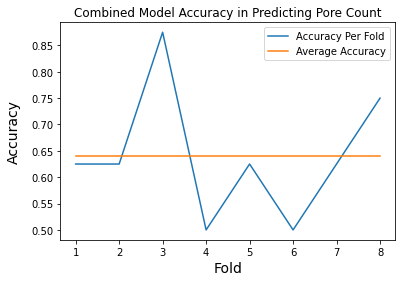

In [35]:

X_test = NUMPY_INPUT_DATA[data_order[64:72],:,:,:]
y_test = y_class_count[data_order[64:72]]


LX = NUMPY_INPUT_DATA[data_order,:,:,:]
LY = y_class_count[data_order]

comb_count_acc = []
for i in range(1,9):
    model_name = 'porosity_bin_model_fold_no_' + str(i) + '.h5'
    model = load_model(model_name)
    pred = model.predict(LX)
    # LY = np.array([1 if a == 0 else 0 for a in Y])
    pred_class = [0 if a < 0.5 else 1 for a in pred]
    correct_X_ind = list(np.where(pred_class==LY)[0])
    print('------------------------------------------------------------------------')
    print(f'Correct predictions in fold {i} ...')
    print(len(correct_X_ind))  
    pred_test = model.predict(X_test)
    pred_class_test = [0 if a < 0.5 else 1 for a in pred_test]
    correct_X_ind = list(np.where(pred_class_test==y_test)[0])
    print(f'Correct Test data predictions for fold {i} ...')
    print(len(correct_X_ind))
    comb_count_acc.append(len(correct_X_ind)/len(X_test))


plt.plot(list(range(1,9)),comb_count_acc, label = 'Accuracy Per Fold')
plt.plot(list(range(1,9)),[np.mean(comb_count_acc) for i in range(8)], label = 'Average Accuracy')
plt.legend()
plt.title('Combined Model Accuracy in Predicting Pore Count',fontsize=12)
plt.ylabel('Accuracy',fontsize=14,labelpad=10)
plt.xlabel('Fold',fontsize=14)
plt.show()
    


### 4.1.2. Printing

In [14]:
NUMPY_INPUT_DATA_printing = TENSOR_INPUT_DATA_PRINTING.numpy()

X_train_class_printing = NUMPY_INPUT_DATA_printing[data_order[0:64],:,:,:]
y_train_class_count_printing = y_class_count[data_order[0:64]]
X_test_class_printing = NUMPY_INPUT_DATA_printing[data_order[64:72],:,:,:]
y_test_class_count_printing = y_class_count[data_order[64:72]]

# Define the K-fold Cross Validator
kfold = KFold(n_splits=8, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
train_acc_per_fold = []
train_loss_per_fold = []
val_acc_per_fold = []
val_loss_per_fold = []
test_acc_per_fold = []
test_loss_per_fold = []

for train, val in kfold.split(X_train_class_printing, y_train_class_count_printing):
    
    train_acc = 0
    val_acc = 0
    test_acc = 0
    # Define the model architecture
    while(train_acc < 0.5 or val_acc < 0.5 or test_acc < 0.5):
        model = Sequential()
        model.add(Conv2D(6, (7, 7), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(4, 129, 15)))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(1, (7, 7), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
        # model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        # model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(6, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(1, activation='sigmoid'))
    
        # Compile the model
        opt = SGD(lr=0.001, momentum=0.9)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        # Fit data to model
        history = model.fit(X_train_class_printing[train], y_train_class_count_printing[train], epochs=100, verbose=0)
        #train_acc_per_fold.append(history.history['accuracy'])
        #train_loss_per_fold.append(history.history['loss'])
        #summarize_diagnostics(fold_no, history)
        model.save('porosity_bin_model_printing_fold_no_'+ str(fold_no) +'.h5')
    
        # Generate generalization metrics
        train_scores = model.evaluate(X_train_class_printing[train], y_train_class_count_printing[train], verbose=0)
        print(f'Train Score for fold {fold_no}: {model.metrics_names[0]} of {train_scores[0]}; {model.metrics_names[1]} of {train_scores[1]*100}%')
        train_acc = train_scores[1]
        
        val_scores = model.evaluate(X_train_class_printing[val], y_train_class_count_printing[val], verbose=0)
        print(f'Val Score for fold {fold_no}: {model.metrics_names[0]} of {val_scores[0]}; {model.metrics_names[1]} of {val_scores[1]*100}%')
        val_acc = val_scores[1]
        
        test_scores = model.evaluate(X_test_class_printing, y_test_class_count_printing, steps=len(X_test_class_printing), verbose = 0)
        print(f'Test data Score for fold {fold_no}: {model.metrics_names[0]} of {test_scores[0]}; {model.metrics_names[1]} of {test_scores[1]*100}%')
        test_acc = test_scores[1]
    
    # Increase fold number
    fold_no = fold_no + 1
    train_acc_per_fold.append(train_scores[1] * 100)
    train_loss_per_fold.append(train_scores[0])
    val_acc_per_fold.append(val_scores[1] * 100)
    val_loss_per_fold.append(val_scores[0])
    test_acc_per_fold.append(test_scores[1] * 100)
    test_loss_per_fold.append(test_scores[0])


------------------------------------------------------------------------
Training for fold 1 ...
Train Score for fold 1: loss of 0.5278714895248413; accuracy of 83.92857313156128%
Val Score for fold 1: loss of 0.8516310453414917; accuracy of 25.0%
Test data Score for fold 1: loss of 0.7429900765419006; accuracy of 37.5%
------------------------------------------------------------------------
Training for fold 1 ...
Train Score for fold 1: loss of 0.26702362298965454; accuracy of 96.42857313156128%
Val Score for fold 1: loss of 1.2719933986663818; accuracy of 25.0%
Test data Score for fold 1: loss of 0.7618809938430786; accuracy of 37.5%
------------------------------------------------------------------------
Training for fold 1 ...
Train Score for fold 1: loss of 0.31042030453681946; accuracy of 98.21428656578064%
Val Score for fold 1: loss of 0.7906292676925659; accuracy of 50.0%
Test data Score for fold 1: loss of 0.868692934513092; accuracy of 25.0%
---------------------------------

3/3 [==============================] - 0s 21ms/step
------------------------------------------------------------------------
Correct predictions in fold 1 ...
52
1/1 [==============================] - 0s 32ms/step
Correct Test data predictions for fold 1 ...
7
3/3 [==============================] - 0s 37ms/step
------------------------------------------------------------------------
Correct predictions in fold 2 ...
47
1/1 [==============================] - 0s 23ms/step
Correct Test data predictions for fold 2 ...
4
3/3 [==============================] - 0s 18ms/step
------------------------------------------------------------------------
Correct predictions in fold 3 ...
52
1/1 [==============================] - 0s 25ms/step
Correct Test data predictions for fold 3 ...
5
3/3 [==============================] - 0s 17ms/step
------------------------------------------------------------------------
Correct predictions in fold 4 ...
47
1/1 [==============================] - 0s 29ms/step
Cor

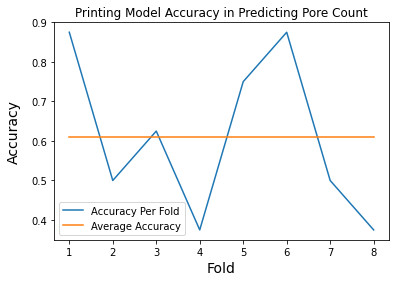

In [36]:
LX = NUMPY_INPUT_DATA_printing[data_order,:,:,:]
LY = y_class_count[data_order] 

printing_count_acc = []
for i in range(1,9):
    model_name = 'porosity_bin_model_printing_fold_no_' + str(i) + '.h5'
    model = load_model(model_name)
    pred = model.predict(LX)
    # LY = np.array([1 if a == 0 else 0 for a in Y])
    pred_class = [0 if a < 0.5 else 1 for a in pred]
    correct_X_ind = list(np.where(pred_class==LY)[0])
    print('------------------------------------------------------------------------')
    print(f'Correct predictions in fold {i} ...')
    print(len(correct_X_ind))  
    pred_test = model.predict(X_test_class_printing)
    pred_class_test = [0 if a < 0.5 else 1 for a in pred_test]
    correct_X_ind = list(np.where(pred_class_test==y_test_class_count_printing)[0])
    print(f'Correct Test data predictions for fold {i} ...')
    print(len(correct_X_ind))
    printing_count_acc.append(len(correct_X_ind)/len(X_test_class_printing))


plt.plot(list(range(1,9)),printing_count_acc, label = 'Accuracy Per Fold')
plt.plot(list(range(1,9)),[np.mean(printing_count_acc) for i in range(8)], label = 'Average Accuracy')
plt.legend()
plt.title('Printing Model Accuracy in Predicting Pore Count',fontsize=12)
plt.ylabel('Accuracy',fontsize=14,labelpad=10)
plt.xlabel('Fold',fontsize=14)
plt.show()
    

### 4.1.3. Milling

In [17]:
NUMPY_INPUT_DATA_milling = TENSOR_INPUT_DATA_MILLING.numpy()

X_train_class_milling = NUMPY_INPUT_DATA_milling[data_order[0:64],:,:,:]
y_train_class_count_milling = y_class_count[data_order[0:64]]
X_test_class_milling = NUMPY_INPUT_DATA_milling[data_order[64:72],:,:,:]
y_test_class_count_milling = y_class_count[data_order[64:72]]

# Define the K-fold Cross Validator
kfold = KFold(n_splits=8, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
train_acc_per_fold = []
train_loss_per_fold = []
val_acc_per_fold = []
val_loss_per_fold = []
test_acc_per_fold = []
test_loss_per_fold = []

for train, val in kfold.split(X_train_class_milling, y_train_class_count_milling):
    
    train_acc = 0
    val_acc = 0
    test_acc = 0
    # Define the model architecture
    while(train_acc < 0.5 or val_acc < 0.5 or test_acc < 0.5):
        model = Sequential()
        model.add(Conv2D(6, (7, 7), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(2, 129, 15)))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(1, (7, 7), activation='relu', kernel_initializer='he_uniform', padding='same'))
        #model.add(MaxPooling2D((2, 2)))
        # model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        # model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(6, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(1, activation='sigmoid'))
    
        # Compile the model
        opt = SGD(lr=0.001, momentum=0.9)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        # Fit data to model
        history = model.fit(X_train_class_milling[train], y_train_class_count_milling[train], epochs=100, verbose=0)
        #train_acc_per_fold.append(history.history['accuracy'])
        #train_loss_per_fold.append(history.history['loss'])
        #summarize_diagnostics(fold_no, history)
        model.save('porosity_bin_model_milling_fold_no_'+ str(fold_no) +'.h5')
    
        # Generate generalization metrics
        train_scores = model.evaluate(X_train_class_milling[train], y_train_class_count_milling[train], verbose=0)
        print(f'Train Score for fold {fold_no}: {model.metrics_names[0]} of {train_scores[0]}; {model.metrics_names[1]} of {train_scores[1]*100}%')
        train_acc = train_scores[1]
        
        val_scores = model.evaluate(X_train_class_milling[val], y_train_class_count_milling[val], verbose=0)
        print(f'Val Score for fold {fold_no}: {model.metrics_names[0]} of {val_scores[0]}; {model.metrics_names[1]} of {val_scores[1]*100}%')
        val_acc = val_scores[1]
        
        test_scores = model.evaluate(X_test_class_milling, y_test_class_count_milling, steps=len(X_test_class_milling), verbose = 0)
        print(f'Test data Score for fold {fold_no}: {model.metrics_names[0]} of {test_scores[0]}; {model.metrics_names[1]} of {test_scores[1]*100}%')
        test_acc = test_scores[1]
    
    # Increase fold number
    fold_no = fold_no + 1
    train_acc_per_fold.append(train_scores[1] * 100)
    train_loss_per_fold.append(train_scores[0])
    val_acc_per_fold.append(val_scores[1] * 100)
    val_loss_per_fold.append(val_scores[0])
    test_acc_per_fold.append(test_scores[1] * 100)
    test_loss_per_fold.append(test_scores[0])


------------------------------------------------------------------------
Training for fold 1 ...
Train Score for fold 1: loss of 0.6106141209602356; accuracy of 80.35714030265808%
Val Score for fold 1: loss of 0.7727962732315063; accuracy of 37.5%
Test data Score for fold 1: loss of 0.7711377739906311; accuracy of 37.5%
------------------------------------------------------------------------
Training for fold 1 ...
Train Score for fold 1: loss of 0.6470349431037903; accuracy of 66.07142686843872%
Val Score for fold 1: loss of 0.8422647714614868; accuracy of 25.0%
Test data Score for fold 1: loss of 0.8029921054840088; accuracy of 25.0%
------------------------------------------------------------------------
Training for fold 1 ...
Train Score for fold 1: loss of 0.6908637285232544; accuracy of 55.35714030265808%
Val Score for fold 1: loss of 0.6992099285125732; accuracy of 37.5%
Test data Score for fold 1: loss of 0.6956983804702759; accuracy of 37.5%
----------------------------------

3/3 [==============================] - 0s 12ms/step
------------------------------------------------------------------------
Correct predictions in fold 1 ...
41
1/1 [==============================] - 0s 22ms/step
Correct Test data predictions for fold 1 ...
5
3/3 [==============================] - 0s 15ms/step
------------------------------------------------------------------------
Correct predictions in fold 2 ...
37
1/1 [==============================] - 0s 36ms/step
Correct Test data predictions for fold 2 ...
5
3/3 [==============================] - 0s 15ms/step
------------------------------------------------------------------------
Correct predictions in fold 3 ...
42
1/1 [==============================] - 0s 58ms/step
Correct Test data predictions for fold 3 ...
5
3/3 [==============================] - 0s 25ms/step
------------------------------------------------------------------------
Correct predictions in fold 4 ...
39
1/1 [==============================] - 0s 21ms/step
Cor

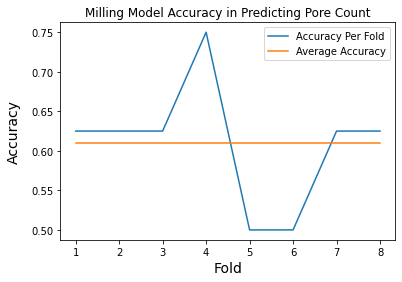

In [37]:
LX = NUMPY_INPUT_DATA_milling[data_order,:,:,:]
LY = y_class_count[data_order] 

milling_count_acc = []
for i in range(1,9):
    model_name = 'porosity_bin_model_milling_fold_no_' + str(i) + '.h5'
    model = load_model(model_name)
    pred = model.predict(LX)
    # LY = np.array([1 if a == 0 else 0 for a in Y])
    pred_class = [0 if a < 0.5 else 1 for a in pred]
    correct_X_ind = list(np.where(pred_class==LY)[0])
    print('------------------------------------------------------------------------')
    print(f'Correct predictions in fold {i} ...')
    print(len(correct_X_ind))  
    pred_test = model.predict(X_test_class_milling)
    pred_class_test = [0 if a < 0.5 else 1 for a in pred_test]
    correct_X_ind = list(np.where(pred_class_test==y_test_class_count_milling)[0])
    print(f'Correct Test data predictions for fold {i} ...')
    print(len(correct_X_ind))
    milling_count_acc.append(len(correct_X_ind)/len(X_test_class_milling))


plt.plot(list(range(1,9)), milling_count_acc, label = 'Accuracy Per Fold')
plt.plot(list(range(1,9)),[np.mean( milling_count_acc) for i in range(8)], label = 'Average Accuracy')
plt.legend()
plt.title('Milling Model Accuracy in Predicting Pore Count',fontsize=12)
plt.ylabel('Accuracy',fontsize=14,labelpad=10)
plt.xlabel('Fold',fontsize=14)
plt.show()
    

## 4.2. %Area Porosity

In [23]:
y_class_area = np.zeros(72)
for i in range(72):
  if y_target_area[i]<=np.mean(y_target_area):
    y_class_area[i] = 0
  else: 
    y_class_area[i] = 1

### 4.2.1. Combined

In [24]:
# CNN Model Architecture - Printing and Milling combined cycles

NUMPY_INPUT_DATA = TENSOR_INPUT_DATA_COMBINED.numpy()


X_train_class = NUMPY_INPUT_DATA[data_order[0:64],:,:,:]
y_train_class_area = y_class_area[data_order[0:64]]
X_test_class = NUMPY_INPUT_DATA[data_order[64:72],:,:,:]
y_test_class_area = y_class_area[data_order[64:72]]


# Define the K-fold Cross Validator
kfold = KFold(n_splits=8, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
train_acc_per_fold = []
train_loss_per_fold = []
val_acc_per_fold = []
val_loss_per_fold = []
test_acc_per_fold = []
test_loss_per_fold = []

for train, val in kfold.split(X_train_class, y_train_class_area):
    
    train_acc = 0
    val_acc = 0
    test_acc = 0
    # Define the model architecture
    while(train_acc < 0.5 or val_acc < 0.5 or test_acc < 0.5):
        model = Sequential()
        model.add(Conv2D(6, (7, 7), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(6, 129, 15)))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(1, (7, 7), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
        # model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        # model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(6, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(1, activation='sigmoid'))
    
        # Compile the model
        opt = SGD(lr=0.001, momentum=0.9)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        # Fit data to model
        history = model.fit(X_train_class[train], y_train_class_area[train], epochs=100, verbose=0)
        #train_acc_per_fold.append(history.history['accuracy'])
        #train_loss_per_fold.append(history.history['loss'])
        #summarize_diagnostics(fold_no, history)
        model.save('porosity_bin_model_fold_no_'+ str(fold_no) +'.h5')
    
        # Generate generalization metrics
        train_scores = model.evaluate(X_train_class[train], y_train_class_area[train], verbose=0)
        print(f'Train Score for fold {fold_no}: {model.metrics_names[0]} of {train_scores[0]}; {model.metrics_names[1]} of {train_scores[1]*100}%')
        train_acc = train_scores[1]
        
        val_scores = model.evaluate(X_train_class[val], y_train_class_area[val], verbose=0)
        print(f'Val Score for fold {fold_no}: {model.metrics_names[0]} of {val_scores[0]}; {model.metrics_names[1]} of {val_scores[1]*100}%')
        val_acc = val_scores[1]
        
        test_scores = model.evaluate(X_test_class, y_test_class_area, steps=len(X_test_class), verbose = 0)
        print(f'Test data Score for fold {fold_no}: {model.metrics_names[0]} of {test_scores[0]}; {model.metrics_names[1]} of {test_scores[1]*100}%')
        test_acc = test_scores[1]
    
    # Increase fold number
    fold_no = fold_no + 1
    train_acc_per_fold.append(train_scores[1] * 100)
    train_loss_per_fold.append(train_scores[0])
    val_acc_per_fold.append(val_scores[1] * 100)
    val_loss_per_fold.append(val_scores[0])
    test_acc_per_fold.append(test_scores[1] * 100)
    test_loss_per_fold.append(test_scores[0])

------------------------------------------------------------------------
Training for fold 1 ...
Train Score for fold 1: loss of 0.687677264213562; accuracy of 57.14285969734192%
Val Score for fold 1: loss of 0.7283454537391663; accuracy of 12.5%
Test data Score for fold 1: loss of 0.6827971339225769; accuracy of 62.5%
------------------------------------------------------------------------
Training for fold 1 ...
Train Score for fold 1: loss of 0.3820503354072571; accuracy of 91.07142686843872%
Val Score for fold 1: loss of 1.0448144674301147; accuracy of 25.0%
Test data Score for fold 1: loss of 0.9453872442245483; accuracy of 37.5%
------------------------------------------------------------------------
Training for fold 1 ...
Train Score for fold 1: loss of 0.4612587094306946; accuracy of 87.5%
Val Score for fold 1: loss of 0.9010484218597412; accuracy of 25.0%
Test data Score for fold 1: loss of 0.7945674657821655; accuracy of 37.5%
------------------------------------------------

3/3 [==============================] - 0s 24ms/step
------------------------------------------------------------------------
Correct predictions in fold 1 ...
56
1/1 [==============================] - 0s 26ms/step
Correct Test data predictions for fold 1 ...
4
3/3 [==============================] - 0s 22ms/step
------------------------------------------------------------------------
Correct predictions in fold 2 ...
65
1/1 [==============================] - 0s 27ms/step
Correct Test data predictions for fold 2 ...
4
3/3 [==============================] - 0s 39ms/step
------------------------------------------------------------------------
Correct predictions in fold 3 ...
66
1/1 [==============================] - 0s 53ms/step
Correct Test data predictions for fold 3 ...
6
3/3 [==============================] - 0s 27ms/step
------------------------------------------------------------------------
Correct predictions in fold 4 ...
38
1/1 [==============================] - 0s 26ms/step
Cor

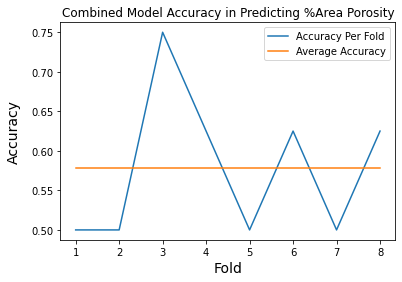

In [38]:
LX = NUMPY_INPUT_DATA[data_order,:,:,:]
LY = y_class_area[data_order]

comb_area_acc = []
for i in range(1,9):
    model_name = 'porosity_bin_model_fold_no_' + str(i) + '.h5'
    model = load_model(model_name)
    pred = model.predict(LX)
    # LY = np.array([1 if a == 0 else 0 for a in Y])
    pred_class = [0 if a < 0.5 else 1 for a in pred]
    correct_X_ind = list(np.where(pred_class==LY)[0])
    print('------------------------------------------------------------------------')
    print(f'Correct predictions in fold {i} ...')
    print(len(correct_X_ind))  
    pred_test = model.predict(X_test)
    pred_class_test = [0 if a < 0.5 else 1 for a in pred_test]
    correct_X_ind = list(np.where(pred_class_test==y_test_class_area)[0])
    print(f'Correct Test data predictions for fold {i} ...')
    print(len(correct_X_ind))
    comb_area_acc.append(len(correct_X_ind)/len(X_test_class_milling))


plt.plot(list(range(1,9)), comb_area_acc, label = 'Accuracy Per Fold')
plt.plot(list(range(1,9)),[np.mean( comb_area_acc) for i in range(8)], label = 'Average Accuracy')
plt.legend()
plt.title('Combined Model Accuracy in Predicting %Area Porosity',fontsize=12)
plt.ylabel('Accuracy',fontsize=14,labelpad=10)
plt.xlabel('Fold',fontsize=14)
plt.show()

### 4.2.2. Printing

In [29]:
NUMPY_INPUT_DATA_printing = TENSOR_INPUT_DATA_PRINTING.numpy()

X_train_printing = NUMPY_INPUT_DATA_printing[data_order[0:64],:,:,:]
y_train_area_printing = y_class_area[data_order[0:64]]
X_test_printing = NUMPY_INPUT_DATA_printing[data_order[64:72],:,:,:]
y_test_area_printing = y_class_area[data_order[64:72]]

# Define the K-fold Cross Validator
kfold = KFold(n_splits=8, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
train_acc_per_fold = []
train_loss_per_fold = []
val_acc_per_fold = []
val_loss_per_fold = []
test_acc_per_fold = []
test_loss_per_fold = []

for train, val in kfold.split(X_train_printing, y_train_area_printing):
    
    train_acc = 0
    val_acc = 0
    test_acc = 0
    # Define the model architecture
    while(train_acc < 0.5 or val_acc < 0.5 or test_acc < 0.5):
        model = Sequential()
        model.add(Conv2D(6, (7, 7), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(4, 129, 15)))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(1, (7, 7), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
        # model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        # model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(6, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(1, activation='sigmoid'))
    
        # Compile the model
        opt = SGD(lr=0.001, momentum=0.9)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        # Fit data to model
        history = model.fit(X_train_printing[train], y_train_area_printing[train], epochs=100, verbose=0)
        #train_acc_per_fold.append(history.history['accuracy'])
        #train_loss_per_fold.append(history.history['loss'])
        #summarize_diagnostics(fold_no, history)
        model.save('porosity_bin_model_printing_fold_no_'+ str(fold_no) +'.h5')
    
        # Generate generalization metrics
        train_scores = model.evaluate(X_train_printing[train], y_train_area_printing[train], verbose=0)
        print(f'Train Score for fold {fold_no}: {model.metrics_names[0]} of {train_scores[0]}; {model.metrics_names[1]} of {train_scores[1]*100}%')
        train_acc = train_scores[1]
        
        val_scores = model.evaluate(X_train_printing[val], y_train_area_printing[val], verbose=0)
        print(f'Val Score for fold {fold_no}: {model.metrics_names[0]} of {val_scores[0]}; {model.metrics_names[1]} of {val_scores[1]*100}%')
        val_acc = val_scores[1]
        
        test_scores = model.evaluate(X_test_printing, y_test_area_printing, steps=len(X_test_printing), verbose = 0)
        print(f'Test data Score for fold {fold_no}: {model.metrics_names[0]} of {test_scores[0]}; {model.metrics_names[1]} of {test_scores[1]*100}%')
        test_acc = test_scores[1]
    
    # Increase fold number
    fold_no = fold_no + 1
    train_acc_per_fold.append(train_scores[1] * 100)
    train_loss_per_fold.append(train_scores[0])
    val_acc_per_fold.append(val_scores[1] * 100)
    val_loss_per_fold.append(val_scores[0])
    test_acc_per_fold.append(test_scores[1] * 100)
    test_loss_per_fold.append(test_scores[0])


------------------------------------------------------------------------
Training for fold 1 ...
Train Score for fold 1: loss of 0.15692302584648132; accuracy of 96.42857313156128%
Val Score for fold 1: loss of 1.55233633518219; accuracy of 50.0%
Test data Score for fold 1: loss of 1.1310837268829346; accuracy of 75.0%
------------------------------------------------------------------------
Training for fold 2 ...
Train Score for fold 2: loss of 0.35553231835365295; accuracy of 91.07142686843872%
Val Score for fold 2: loss of 1.1012513637542725; accuracy of 12.5%
Test data Score for fold 2: loss of 0.9032222628593445; accuracy of 37.5%
------------------------------------------------------------------------
Training for fold 2 ...
Train Score for fold 2: loss of 0.6832218170166016; accuracy of 53.57142686843872%
Val Score for fold 2: loss of 0.6837044954299927; accuracy of 62.5%
Test data Score for fold 2: loss of 0.6872790455818176; accuracy of 25.0%
----------------------------------

3/3 [==============================] - 0s 25ms/step
------------------------------------------------------------------------
Correct predictions in fold 1 ...
64
1/1 [==============================] - 0s 41ms/step
Correct Test data predictions for fold 1 ...
6
3/3 [==============================] - 0s 31ms/step
------------------------------------------------------------------------
Correct predictions in fold 2 ...
59
1/1 [==============================] - 0s 27ms/step
Correct Test data predictions for fold 2 ...
5
3/3 [==============================] - 0s 17ms/step
------------------------------------------------------------------------
Correct predictions in fold 3 ...
66
1/1 [==============================] - 0s 26ms/step
Correct Test data predictions for fold 3 ...
4
3/3 [==============================] - 0s 18ms/step
------------------------------------------------------------------------
Correct predictions in fold 4 ...
57
1/1 [==============================] - 0s 27ms/step
Cor

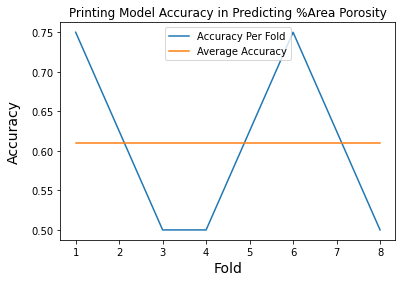

In [39]:
LX = NUMPY_INPUT_DATA_printing[data_order,:,:,:]
LY = y_class_area[data_order] 

printing_area_acc = []
for i in range(1,9):
    model_name = 'porosity_bin_model_printing_fold_no_' + str(i) + '.h5'
    model = load_model(model_name)
    pred = model.predict(LX)
    # LY = np.array([1 if a == 0 else 0 for a in Y])
    pred_class = [0 if a < 0.5 else 1 for a in pred]
    correct_X_ind = list(np.where(pred_class==LY)[0])
    print('------------------------------------------------------------------------')
    print(f'Correct predictions in fold {i} ...')
    print(len(correct_X_ind))  
    pred_test = model.predict(X_test_printing)
    pred_class_test = [0 if a < 0.5 else 1 for a in pred_test]
    correct_X_ind = list(np.where(pred_class_test==y_test_area_printing)[0])
    print(f'Correct Test data predictions for fold {i} ...')
    print(len(correct_X_ind))
    printing_area_acc.append(len(correct_X_ind)/len(X_test_class_milling))


plt.plot(list(range(1,9)), printing_area_acc, label = 'Accuracy Per Fold')
plt.plot(list(range(1,9)),[np.mean( printing_area_acc) for i in range(8)], label = 'Average Accuracy')
plt.legend()
plt.title('Printing Model Accuracy in Predicting %Area Porosity',fontsize=12)
plt.ylabel('Accuracy',fontsize=14,labelpad=10)
plt.xlabel('Fold',fontsize=14)
plt.show()

### 4.2.3. Milling

In [32]:
NUMPY_INPUT_DATA_milling = TENSOR_INPUT_DATA_MILLING.numpy()

X_train_milling = NUMPY_INPUT_DATA_milling[data_order[0:64],:,:,:]
y_train_area_milling = y_class_area[data_order[0:64]]
X_test_milling = NUMPY_INPUT_DATA_milling[data_order[64:72],:,:,:]
y_test_area_milling = y_class_area[data_order[64:72]]

# Define the K-fold Cross Validator
kfold = KFold(n_splits=8, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
train_acc_per_fold = []
train_loss_per_fold = []
val_acc_per_fold = []
val_loss_per_fold = []
test_acc_per_fold = []
test_loss_per_fold = []

for train, val in kfold.split(X_train_milling, y_train_area_milling):
    
    train_acc = 0
    val_acc = 0
    test_acc = 0
    # Define the model architecture
    while(train_acc < 0.5 or val_acc < 0.5 or test_acc < 0.5):
        model = Sequential()
        model.add(Conv2D(6, (7, 7), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(2, 129, 15)))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(1, (7, 7), activation='relu', kernel_initializer='he_uniform', padding='same'))
        #model.add(MaxPooling2D((2, 2)))
        # model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        # model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(6, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(1, activation='sigmoid'))
    
        # Compile the model
        opt = SGD(lr=0.001, momentum=0.9)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        # Fit data to model
        history = model.fit(X_train_milling[train], y_train_area_milling[train], epochs=100, verbose=0)
        #train_acc_per_fold.append(history.history['accuracy'])
        #train_loss_per_fold.append(history.history['loss'])
        #summarize_diagnostics(fold_no, history)
        model.save('porosity_bin_model_milling_fold_no_'+ str(fold_no) +'.h5')
    
        # Generate generalization metrics
        train_scores = model.evaluate(X_train_milling[train], y_train_area_milling[train], verbose=0)
        print(f'Train Score for fold {fold_no}: {model.metrics_names[0]} of {train_scores[0]}; {model.metrics_names[1]} of {train_scores[1]*100}%')
        train_acc = train_scores[1]
        
        val_scores = model.evaluate(X_train_milling[val], y_train_area_milling[val], verbose=0)
        print(f'Val Score for fold {fold_no}: {model.metrics_names[0]} of {val_scores[0]}; {model.metrics_names[1]} of {val_scores[1]*100}%')
        val_acc = val_scores[1]
        
        test_scores = model.evaluate(X_test_milling, y_test_area_milling, steps=len(X_test), verbose = 0)
        print(f'Test data Score for fold {fold_no}: {model.metrics_names[0]} of {test_scores[0]}; {model.metrics_names[1]} of {test_scores[1]*100}%')
        test_acc = test_scores[1]
    
    # Increase fold number
    fold_no = fold_no + 1
    train_acc_per_fold.append(train_scores[1] * 100)
    train_loss_per_fold.append(train_scores[0])
    val_acc_per_fold.append(val_scores[1] * 100)
    val_loss_per_fold.append(val_scores[0])
    test_acc_per_fold.append(test_scores[1] * 100)
    test_loss_per_fold.append(test_scores[0])


------------------------------------------------------------------------
Training for fold 1 ...
Train Score for fold 1: loss of 0.6904529333114624; accuracy of 53.57142686843872%
Val Score for fold 1: loss of 0.7079496383666992; accuracy of 37.5%
Test data Score for fold 1: loss of 0.6805781722068787; accuracy of 62.5%
------------------------------------------------------------------------
Training for fold 1 ...
Train Score for fold 1: loss of 0.6414384841918945; accuracy of 78.57142686843872%
Val Score for fold 1: loss of 0.6210775971412659; accuracy of 87.5%
Test data Score for fold 1: loss of 0.7258933186531067; accuracy of 25.0%
------------------------------------------------------------------------
Training for fold 1 ...
Train Score for fold 1: loss of 0.45664119720458984; accuracy of 82.14285969734192%
Val Score for fold 1: loss of 0.4588933289051056; accuracy of 87.5%
Test data Score for fold 1: loss of 0.8720085620880127; accuracy of 37.5%
---------------------------------

3/3 [==============================] - 0s 12ms/step
------------------------------------------------------------------------
Correct predictions in fold 1 ...
53
1/1 [==============================] - 0s 25ms/step
Correct Test data predictions for fold 1 ...
4
3/3 [==============================] - 0s 10ms/step
------------------------------------------------------------------------
Correct predictions in fold 2 ...
45
1/1 [==============================] - 0s 25ms/step
Correct Test data predictions for fold 2 ...
4
3/3 [==============================] - 0s 12ms/step
------------------------------------------------------------------------
Correct predictions in fold 3 ...
50
1/1 [==============================] - 0s 22ms/step
Correct Test data predictions for fold 3 ...
4
3/3 [==============================] - 0s 10ms/step
------------------------------------------------------------------------
Correct predictions in fold 4 ...
43
1/1 [==============================] - 0s 23ms/step
Cor

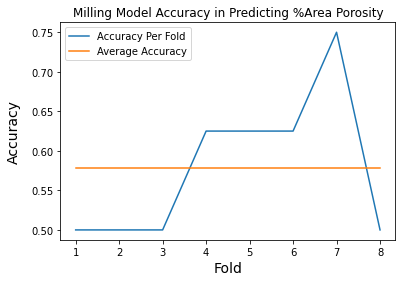

In [40]:
LX = NUMPY_INPUT_DATA_milling[data_order,:,:,:]
LY = y_class_area[data_order] 

milling_area_acc = []
for i in range(1,9):
    model_name = 'porosity_bin_model_milling_fold_no_' + str(i) + '.h5'
    model = load_model(model_name)
    pred = model.predict(LX)
    # LY = np.array([1 if a == 0 else 0 for a in Y])
    pred_class = [0 if a < 0.5 else 1 for a in pred]
    correct_X_ind = list(np.where(pred_class==LY)[0])
    print('------------------------------------------------------------------------')
    print(f'Correct predictions in fold {i} ...')
    print(len(correct_X_ind))  
    pred_test = model.predict(X_test_milling)
    pred_class_test = [0 if a < 0.5 else 1 for a in pred_test]
    correct_X_ind = list(np.where(pred_class_test==y_test_area_milling)[0])
    print(f'Correct Test data predictions for fold {i} ...')
    print(len(correct_X_ind))
    milling_area_acc.append(len(correct_X_ind)/len(X_test_class_milling))


plt.plot(list(range(1,9)), milling_area_acc, label = 'Accuracy Per Fold')
plt.plot(list(range(1,9)),[np.mean( milling_area_acc) for i in range(8)], label = 'Average Accuracy')
plt.legend()
plt.title('Milling Model Accuracy in Predicting %Area Porosity',fontsize=12)
plt.ylabel('Accuracy',fontsize=14,labelpad=10)
plt.xlabel('Fold',fontsize=14)
plt.show()

In [60]:
!pip install nbconvert


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [62]:
%%shell 
jupyter nbconvert --to HTML /content/ISEN613_Project_Notebook.ipynb

[NbConvertApp] Converting notebook /content/ISEN613_Project_Notebook.ipynb to HTML
[NbConvertApp] Writing 917688 bytes to /content/ISEN613_Project_Notebook.html
